Para hacer apply a un daskdataframe es necesario pasarle meta que es el tipo de datos que va a tener. https://stackoverflow.com/a/44437675

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
# import dask.dataframe as dd # en caso de tener muchos datos
import locale
import re
locale.setlocale(locale.LC_TIME, "es_ES") 

'es_ES'

# Unión de los CSV

In [ ]:
files = glob.glob("datos/Coches_Cuadro_Oferta_Real/*/Coches_Cuadro_Oferta_Real_*.csv")
# Read column names from file
cols = list(pd.read_csv(files[0], sep=';',nrows=1))
cols = list(filter(lambda col: col.strip(), cols))


#Cargamos los datos y especificamos los tipos en las columnas, así como eliminar la última columna por ser vacia
dfs = [pd.read_csv(f, header=0, sep=";",encoding = "ISO-8859-1",dtype={'Elinea':'str'},usecols=cols) for f in files]
df = pd.concat(dfs,ignore_index=True)


# Elimnar el último dataframe del último fichero de la memoria
del dfs

df.to_csv('datos/Coches_Cuadro_Oferta_Real/autobuses_oferta_real.csv')

# Análisis

In [105]:
oferta = pd.read_csv('datos/Coches_Cuadro_Oferta_Real/autobuses_oferta_real.csv',dtype={'Elinea':'str'})
oferta.drop(columns='Unnamed: 0',inplace=True)

1. Ponemos la columna `FServicio` en formato fecha
2. Creamos una nueva columna para saber si esa fecha era un día de lunes a viernes (True) o sábado y domingo (False)
3. Completamos la columna `Coches` con 0 si no tienen valor.

In [106]:
oferta['FServicio'] = pd.to_datetime(oferta['FServicio'], format='%d/%m/%Y')
oferta.loc[oferta['FServicio'].dt.dayofweek > 4,'Diario'] = False
oferta['Diario'].fillna(True,inplace=True)
oferta['Coches'].fillna(0,inplace=True)

Creamos una tabla auxiliar para crear una nueva columna `fechaCorta` que tendrá el mes y año de `FServicio` y la unimos con el conjunto de datos que estamos usando `oferta`

In [107]:
tiempos = pd.DataFrame({'FServicio': pd.date_range('2019-01-01', '2021-12-31', freq='D')})
tiempos['fechaCorta'] = tiempos['FServicio'].dt.strftime('%B.%Y')
if 'fechaCorta' not in oferta.columns:
    oferta = oferta.join(tiempos.set_index('FServicio'),on='FServicio')
    
oferta.head()

,CLinea,Elinea,Denominacion,FServicio,IDFranja,Intervalo,Coches,Diario,fechaCorta
0,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H07,070000 - 075959,2.0,True,enero.2019
1,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H08,080000 - 085959,3.0,True,enero.2019
2,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H09,090000 - 095959,3.0,True,enero.2019
3,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H10,100000 - 105959,4.0,True,enero.2019
4,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,H11,110000 - 115959,4.0,True,enero.2019


In [108]:
# https://stackoverflow.com/questions/38869778/pandas-set-column-equal-to-grouped-sum-of-another-column?noredirect=1&lq=1

oferta['MediaCochesMes'] = oferta.groupby(by=['CLinea', 'fechaCorta', 'IDFranja']).Coches.transform('mean')

# Calendar Dates GFTS
Este archivo contiene fechas en las ha cambiado el tipo de servicio de `Laborable` a `Festivo`.

In [109]:
calendar_dates = pd.read_csv('datos/GFTS/gfts_calendar_dates.csv')
calendar_dates['date_formated'] = pd.to_datetime(calendar_dates['date_formated'])
calendar_festivo = calendar_dates.loc[calendar_dates['exception_type']==1,['exception_type','date_formated']]

¿Por qué al hacer merge pasamos de tener 3.5M de filas a tener 7.5M?

[Explicación de StackOverflow](https://stackoverflow.com/a/39019766)

In [110]:
# tmp = oferta.merge(right=calendar_festivo,\
#                 right_on='date_formated',\
#                 left_on='FServicio',\
#                 how='left'\
#             ).drop(columns='date_formated')

oferta = oferta.join(other=calendar_festivo.set_index('date_formated'), on='FServicio')
oferta['Diario'] = oferta['exception_type']!=1
oferta.drop_duplicates(inplace=True)

In [111]:
oferta.drop(columns=['exception_type'],inplace=True)

In [112]:
oferta.reset_index(drop=True, inplace=True)

In [113]:
# Comprobamos que la primera fecha del calendario pone Diario a False
oferta[oferta['FServicio']==calendar_festivo.iloc[0,1]].head(2)

,CLinea,Elinea,Denominacion,FServicio,IDFranja,Intervalo,Coches,Diario,fechaCorta,MediaCochesMes
2016,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-04-18,H07,070000 - 075959,3.0,False,abril.2019,5.5
2017,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-04-18,H08,080000 - 085959,4.0,False,abril.2019,6.5


In [74]:
# Nuevo dataframe con sólo los días que sean lunes a viernes
# entresemana = oferta[oferta['Diario']==True].copy()
# entresemana['MediaCochesLaborables'] = entresemana.groupby(by=['CLinea', 'fechaCorta', 'IDFranja']).Coches.transform('mean')

#### IMPORTANTE ####
# Esta sólo agregando el valor de MediaCochesLaborables a los días que son laborables y no a todo el mes

# oferta['MediaCochesLaborables'] = oferta[oferta['Diario']==True].groupby(by=['CLinea', 'fechaCorta', 'IDFranja'])['Coches'].transform('mean')

In [143]:
medias = oferta[oferta['Diario']==True].copy()

In [150]:
medias['MediaCochesLaborables'] = medias.groupby(by=['CLinea','IDFranja','fechaCorta'])['Coches'].transform('mean')

In [162]:
# medias[medias['MediaCochesLaborables']!=medias['MediaCochesMes']]

In [187]:
# medias['year'] = medias['FServicio'].dt.year
# medias['month_number'] = medias['FServicio'].dt.month
# medias['month'] = medias['FServicio'].dt.month_name()
medias = medias.loc[:,['CLinea','Elinea','Denominacion','FServicio','fechaCorta','IDFranja','MediaCochesMes','MediaCochesLaborables']].drop_duplicates(subset=['CLinea','IDFranja','fechaCorta'])

¿La MediaCochesMes == MediaCochesLaborables en algunos meses?

Con estas últimas operaciones hemos extendido a todas las filas que sean del mes M y del año A su valor de MediaCochesMes y MediaCochesLaborables.

In [ ]:
# oferta.to_csv('datos/oferta.csv',encoding='utf8',index=False)

In [199]:
#Función para gráficar con matplotlib la línea en la fronja que corresponda

def graficar(dataset,num_linea,franja,valores='MediaCochesMes',guardar=False):
    fig, axes = plt.subplots(figsize=(12, 5),dpi=100)
    axes.spines.right.set_visible(False)
    axes.spines.top.set_visible(False)


    # num_linea = 21
    # franja = 'H10'

    # Filtro por linea y franja
    dataset = dataset[dataset['CLinea']==num_linea]
    dataset = dataset[dataset['IDFranja']==franja]    
    data = dataset.reset_index(drop=True)
    
    if len(data)==0:
        listado_franjas = dataset.loc[dataset['CLinea']==num_linea,'IDFranja'].unique()
        raise Exception(f"Las franjas horarias de la linea {num_linea} son: {listado_franjas}") 
        
    lineaPublico = str(data.loc[0,"Elinea"])
    cartel_linea = str(data.loc[0,"Denominacion"])

    # Visualizo los datos (media) y fechas
    for fecha in data['FServicio'].dt.year.unique():
        axes.plot(data.loc[data['FServicio'].dt.year == fecha,'fechaCorta'],data.loc[data['FServicio'].dt.year == fecha, valores],'-o',label='Franja: '+ franja +'\nAño: '+str(fecha))


    # Configuraciones visuales
    axes.set_xticks(data['fechaCorta'])
    axes.set_xticklabels(data['fechaCorta'], rotation = 45, ha="right")
    
    # axes.set_yticks(range(0,int(data[valores].max()+3)))
    axes.set_ylim([0,data[valores].max()+3])

    xTicks = axes.get_xticklabels()
    indices_enero = [i for i, fecha in enumerate(data['FServicio']) if fecha.month==1]
    # for i,fecha in enumerate(data['FServicio']):
    #     if fecha.month==1:
    #         print(fecha)

    for indiceEnero in indices_enero:
        xTicks[indiceEnero].set_weight('bold')

    # Título y nombre ejes
    axes.set_xlabel('Fecha')
    axes.set_ylabel('# Autobuses')
    axes.set_title(label=f'Evolución núm. autobuses ({valores})\nLÍNEA {lineaPublico}: {cartel_linea}',pad=20)

    axes.grid(linestyle='--', linewidth=1, axis='both')

    leg = axes.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0)

    # FALTA POR HACER ESTO-> Poner una caja debajo de las leyedenas que muestren datos como máx y min
    # p = leg.get_window_extent()
    # print(p)
    # axes.annotate('Annotation Text', (p.p0[0], p.p1[1]+10), (p.p0[0], p.p1[1]), 
    #             xycoords='figure pixels', zorder=9)


    # plt.legend(loc="lower right") # Esto puede deshabilitar quitando la línea
    if guardar:
        plt.savefig(fname=f'images/LÍNEA_{num_linea}_{franja}_{cartel_linea}.jpg',format='jpg', bbox_inches='tight', dpi=200)


    fig.set_facecolor('white')

    plt.show()

In [ ]:
oferta[(oferta['CLinea']==25)&(oferta['IDFranja']=='H07')].drop_duplicates(subset=['CLinea','IDFranja','fechaCorta']).reset_index(drop=True)

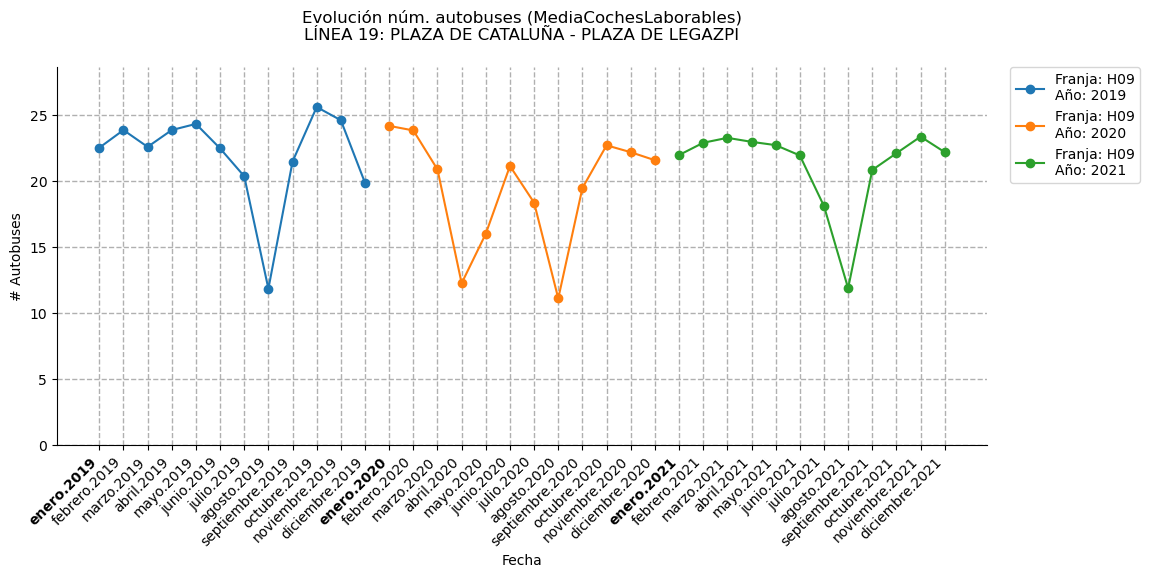

In [233]:
graficar(dataset=medias,\
            num_linea=19,\
            franja='H09',
            valores='MediaCochesLaborables')

In [227]:
coches_mes = medias\
                    .drop_duplicates(['CLinea','fechaCorta','IDFranja'])\
                        .reset_index(drop=True)\
                        .loc[:,['CLinea','FServicio','IDFranja','MediaCochesMes','MediaCochesLaborables']].copy()

In [228]:
# Creo una key única que es de la forma `CLinea_IDFranja_NombreMes_Año`
for index in range(0,3):
    coches_mes[f'key_{index}'] = coches_mes['CLinea'].astype(str).str.zfill(3)\
                +'_'+coches_mes['IDFranja']\
                +'_'+coches_mes['FServicio'].dt.month_name()\
                +'_'+ (coches_mes['FServicio'].dt.year-index).astype(str)

In [229]:
coches_mes.head(2)

,CLinea,FServicio,IDFranja,MediaCochesMes,MediaCochesLaborables,key_0,key_1,key_2
0,1,2019-01-01,H07,5.580645,5.580645,001_H07_January_2019,001_H07_January_2018,001_H07_January_2017
1,1,2019-01-01,H08,6.580645,6.580645,001_H08_January_2019,001_H08_January_2018,001_H08_January_2017


In [230]:
# En caso de que ya tenga las columnas las elimino para que no me de problemas
indices = [i for i, item in enumerate(coches_mes.columns) if re.search('avg_key_', item)]
if len(indices)>0:
    coches_mes.drop(coches_mes.columns[indices],axis=1,inplace=True)

 # VLOOKUP EN PYTHON  
for idx in range(1,3):
    coches_mes.insert(len(coches_mes.columns), f'avg_key_{idx}', coches_mes[f'key_{idx}'].map(coches_mes.set_index(f'key_0')['MediaCochesLaborables']))

In [234]:
coches_mes = coches_mes[sorted(coches_mes.columns)]
coches_mes[coches_mes['CLinea']<310]

,CLinea,FServicio,IDFranja,MediaCochesLaborables,MediaCochesMes,avg_key_1,avg_key_2,key_0,key_1,key_2
0,1,2019-01-01,H07,5.580645,5.580645,NaN,NaN,001_H07_January_2019,001_H07_January_2018,001_H07_January_2017
1,1,2019-01-01,H08,6.580645,6.580645,NaN,NaN,001_H08_January_2019,001_H08_January_2018,001_H08_January_2017
2,1,2019-01-01,H09,7.387097,7.387097,NaN,NaN,001_H09_January_2019,001_H09_January_2018,001_H09_January_2017
3,1,2019-01-01,H10,8.903226,8.903226,NaN,NaN,001_H10_January_2019,001_H10_January_2018,001_H10_January_2017
4,1,2019-01-01,H11,9.193548,9.193548,NaN,NaN,001_H11_January_2019,001_H11_January_2018,001_H11_January_2017
...,...,...,...,...,...,...,...,...,...,...
131923,247,2021-12-01,H20,2.928571,2.903226,2.928571,2.857143,247_H20_December_2021,247_H20_December_2020,247_H20_December_2019
131924,247,2021-12-01,H21,2.928571,2.903226,2.928571,2.857143,247_H21_December_2021,247_H21_December_2020,247_H21_December_2019
131925,247,2021-12-01,H22,2.962963,2.933333,2.962963,2.888889,247_H22_December_2021,247_H22_December_2020,247_H22_December_2019
131926,247,2021-12-01,H23,2.000000,2.000000,3.000000,2.923077,247_H23_December_2021,247_H23_December_2020,247_H23_December_2019


# POSIBLE IDEA
Para poder comparar las líneas, podemos hacer una media nueva sobre las horas puntas de la mañana (de H07 hasta las H09).

Al reducir a esas franjas horarias, son las franjas horarias de mayor afluencia se Comunidad de Madrid, eliminamos la columna de `IDFranja` y podemos crear un nuevo dataframe más simple de la forma siguiente:

| Línea | AVG_2019 | AVG_2020 | AVG_2021 |
| ----- | -------- | -------- | -------- |
|  25   |    X     |    Y     |     Z    |

Calcular para cada linea y franja horaria la diferencia de autobuses por mes para cada año 

| Línea |   Fecha    | Diff.AñoAnterior |
|-------|   -------  |------------------|
|   1   | enero.2020 |       10%        |
|   1   | enero.2021 |       -5%        |


#### Duda
Si quisiera mirar la línea que mayor diferencia ha tenido (sin tener en consideración la pandemia) me saldría ordenado por franjas horarias, pero no por linea y franja.

# Hora punta Madrid
Según el informe anual de [2018 de CRTM](https://www.crtm.es/media/712934/edm18_sintesis.pdf#page=54) y [Encuesta Sintética de Movilidad - ESM14](https://www.crtm.es/media/519661/esm_2014.pdf) las franjas horarias quedan de la siguiente manera:

- La hora punta de la mañana es la comprendida entre las 08h-09h.
- El periodo valle se produce entra las 10h-13h.
- La hora punta del mediodía es la comprendida entre las 14h-15h.
- La hora punta del mediodía es la comprendida entre las 17h-20h.

_Los viajes por movilidad ocupacional, trabajo y estudios, se producen en dos periodos concretos, entre las 6h y las 9h de la mañana y entre la 13h y las 15 h de la tarde. Existe otro pico entre las 16h y las 18h relacionado con la salida de los centros escolares o el fin de la jornada laboral._


![Distribución horaria de los viajeros según su actividad](markdown_images/distribución_horaria_viajeros_actividad.png)

In [237]:
# Esto seguro que puedo dejarlo en un mismo dataframe
diurnas_regulares = medias[medias['CLinea']<500]

horas = ['H07','H08','H09']

horapunta = diurnas_regulares[diurnas_regulares['IDFranja'].isin(horas)].copy()

In [239]:
horapunta.head(2)

,CLinea,Elinea,Denominacion,FServicio,fechaCorta,IDFranja,MediaCochesMes,MediaCochesLaborables
0,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,enero.2019,H07,5.580645,5.580645
1,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,enero.2019,H08,6.580645,6.580645


In [247]:
# Esto me va a crear una nueva columna, pero lo suyo sería tener
# una nueva columnay una fila que tuviera como IDFranja == horapuna.

horapunta['MediaCochesHoraPunta'] = horapunta.groupby(by=['CLinea', 'fechaCorta'])['MediaCochesLaborables'].transform('mean')
tmp = horapunta.drop_duplicates(['CLinea','fechaCorta']).copy()

In [248]:
tmp.head(2)

,CLinea,Elinea,Denominacion,FServicio,fechaCorta,IDFranja,MediaCochesMes,MediaCochesLaborables,MediaCochesHoraPunta
0,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-01-01,enero.2019,H07,5.580645,5.580645,6.516129
584,1,1,PLAZA DE CRISTO REY - PROSPERIDAD,2019-02-01,febrero.2019,H07,5.857143,5.857143,6.809524


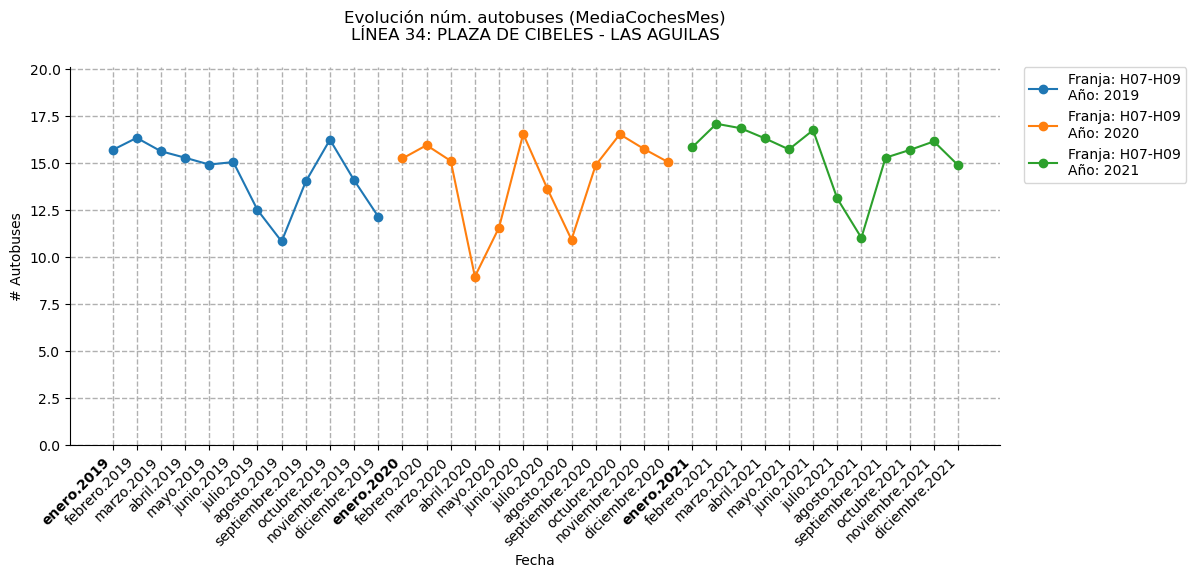

In [251]:
tmp.reset_index(drop=True,inplace=True)
tmp.loc[:,'IDFranja'] = 'H07-H09'

graficar(dataset=tmp.copy(),num_linea=34,franja='H07-H09',valores='MediaCochesMes') # [MediaCochesMes, MediaCochesLaborables, MediaCochesHoraPunta]

In [ ]:
####################
# ESTO SON PRUEBAS #
####################

# tmp = media_buses.copy()
# tmp['mes'] = tmp['FServicio'].dt.month
# tmp['year'] = tmp['FServicio'].dt.year
# tmp['key_1'] = tmp['CLinea'].astype(str).str.zfill(3)+tmp['IDFranja']+tmp['mes'].astype(str)+tmp['year'].astype(str)
# tmp['key_2'] = tmp['CLinea'].astype(str).str.zfill(3)+tmp['IDFranja']+tmp['mes'].astype(str)+(tmp['year']-1).astype(str)
# tmp['key_3'] = tmp['CLinea'].astype(str).str.zfill(3)+tmp['IDFranja']+tmp['mes'].astype(str)+(tmp['year']-2).astype(str)
# tmp2 = tmp.loc[:,['key_1','key_2','key_3','FServicio','fechaCorta','CLinea','IDFranja','avg_coches']]

# # https://stackoverflow.com/questions/41511730/python-function-similar-to-vlookup-excel
# if 'avg_key_2' in tmp2.columns:
#     tmp2.drop(columns=['avg_key_2'],inplace=True)
# if 'avg_key_3' in tmp2.columns:
#     tmp2.drop(columns=['avg_key_3'],inplace=True)

# tmp2.insert(len(tmp2.columns), 'avg_key_2', tmp2['key_2'].map(tmp2.set_index('key_1')['avg_coches']))
# tmp2.insert(len(tmp2.columns), 'avg_key_3', tmp2['key_3'].map(tmp2.set_index('key_1')['avg_coches']))
# # tmp2.fillna(0,inplace=True)
# tmp2.reset_index(inplace=True,drop=True)
# tmp2['diff_key1_key2'] = (tmp2['avg_coches']-tmp2['avg_key_2'])
# tmp2['diff_key1_key3'] = (tmp2['avg_coches']-tmp2['avg_key_3'])
# tmp2.sort_values(by='diff_key1_key3')
# tmp3 = tmp2[tmp2['FServicio'].dt.year!=2020].sort_values(by='diff')
# tmp3 = tmp3[tmp3['CLinea']<500]
# tmp3['diff'].fillna(0,inplace=True)
# dff = tmp2.sort_values(by='diff_key1_key3').reset_index(drop=True).loc[0,:]
# graficar(num_linea=dff['CLinea'],franja=dff['IDFranja'])

# Líneas con mayor afluencia de pasajeros
Según este tweet de [@EMTmadrid](https://twitter.com/emtmadrid/status/956855958369701889?lang=es) las líneas con mayor demanda en 2017 son: L34, L27, L70, C1, C2, L31, L28, L35 y L17.

La demanda de estas líneas supone un 26.5% del total, equivalente 113 millones de pasajeros en dicho año.

In [ ]:
numero_viajeros = pd.read_csv('datos/Grado_de_Ocupación/numero_viajeros.csv')
aclaraciones = pd.read_csv('datos/Grado_de_Ocupación/aclaraciones_ocupacion_lineas.csv')

In [ ]:
ranking = numero_viajeros.iloc[:,:3].copy()

In [ ]:
for year in range(2014,int(numero_viajeros.columns[-1])):
    rank = numero_viajeros.loc[:,['Código',str(year)]].sort_values(by=[str(year)], ascending=False)
    rank[str(year)] = rank.reset_index().index+1
    # numero_viajeros[str(year)].sort_values(ascending=False).reset_index().rename(columns={'index':'Código'})
    ranking = ranking.merge(rank)

In [ ]:
data = ranking.sort_values(by='2021').iloc[0:10,:]

fig, axes = plt.subplots(figsize=(8, 5),dpi=100)
axes.spines.right.set_visible(False)
axes.spines.top.set_visible(False)

# Visualizo los datos (avg_coches) y fechas

years = data.columns[3:]
axes.plot(years,data.iloc[:,3:].T,'-o',label=data['Etiqueta'] + ' | ' +data['Denominación'])

# Título y nombre ejes
# axes.set_xlabel('Años')
axes.set_ylabel('Posición')
axes.set_title(label=f'Ranking líneas con mayor usuarios',pad=20)
   
axes.set_xticks(range(0,len(years)))
axes.set_xticklabels(years)
axes.set_ylim(0,11)
axes.set_yticks(range(1,11))
axes.invert_yaxis()

axes.grid(color="#172a3d", linestyle='--', linewidth=1, axis='y', alpha=0.15)
axes.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0)
fig.set_facecolor('white')
plt.show()

# Aclaraciones

|    |   Año | Informacion                                                                                 |
|---:|------:|:--------------------------------------------------------------------------------------------|
|  0 |  2019 | (1)  El Servicio Especial 721 solo funciona los días de evento en el Estadio Metropolitano. |
|  1 |  2019 | (2)  El 1 de abril de 2019 el Servicio Especial 722 se transforma en la línea 166.          |
|  2 |  2020 | (1)  El Servicio Especial 721 solo funciona los días de evento en el Estadio Metropolitano. |
|  3 |  2020 | (2)  El 18 de febrero se crea la línea 361.                                                 |
|  4 |  2020 | (3)  El 3 de marzo de 2020 la línea 602 se prolonga y se transforma en la línea 362.        |
|  5 |  2020 | (4)  El 16 de marzo de 2020 el Servicio Especial 723 se transforma en la línea 159.         |
|  6 |  2020 | (5)  El Servicio Especial 710 funciona del 23 de marzo al 24 de mayo de 2020.               |
|  7 |  2020 | (6)  El 15 de septiembre se crea la línea 363.                                              |
|  8 |  2020 | (7)  El 7 de octubre se crea el Servicio Especial 712.                                      |
|  9 |  2021 | (1)  El Servicio Especial 721 solo funciona los días de evento en el Estadio Metropolitano. |
| 10 |  2021 | (2)  El 16 de febrero se crea la línea 167.                                                 |
| 11 |  2021 | (3)  El 2 de marzo se crea la línea 163.                                                    |
| 12 |  2021 | (4)  El 17 de marzo se crea la línea 405.                                                   |
| 13 |  2021 | (5)  El 1 de septiembre se crea el Servicio Especial 708.                                   |



Además, hay otras aclaraciones que no se contemplan como el cambio de `Servicio Especial` a  `Regular` de la línea con tramo `MAR DE CRISTAL - VALDEBEBAS`

In [ ]:
pd.concat([numero_viajeros.loc[(numero_viajeros['Código']==171)].sort_values(by='2021',ascending=False),\
            numero_viajeros.loc[(numero_viajeros['Código']==799)].sort_values(by='2021',ascending=False)]
            )

In [ ]:
numero_viajeros.loc[(numero_viajeros['Código']==171)].sort_values(by='2021',ascending=False).combine_first(numero_viajeros.loc[(numero_viajeros['Código']==799)].sort_values(by='2021',ascending=False)).iloc[:,3:].max().to_frame().T

In [ ]:
numero_viajeros['media'] = numero_viajeros.iloc[:,3:].apply(lambda x: x.mean(),axis=1)

In [ ]:
numero_viajeros.sort_values(by='media',ascending=False)

In [ ]:
numero_viajeros[numero_viajeros['Etiqueta']=='SE']

In [ ]:
fig, axes = plt.subplots(figsize=(8, 5),dpi=100)
# Visualizo los datos (avg_coches) y fechas
years = numero_viajeros.columns[3:]


axes.plot(numero_viajeros.columns[3:],numero_viajeros[numero_viajeros['Código']==25].iloc[:,3:].T,'-o')
axes.grid(color="#172a3d", linestyle='--', linewidth=1, axis='y', alpha=0.15)

# Título y nombre ejes
axes.set_xlabel('Años')
axes.set_ylabel('Núm. viajeros (Millones)')
axes.set_title(label=f'Ranking líneas con mayor usuarios',pad=20)
   
# axes.set_xticks(range(0,len(years)))
# axes.set_xticklabels(years)
# axes.set_ylim(0,11)
# axes.set_yticks(range(1,11))
# axes.invert_yaxis()

axes.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0)
fig.set_facecolor('white')
plt.show()